<a href="https://colab.research.google.com/github/cehkop/Deep_learning_school_MIPT/blob/main/homework/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>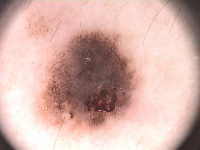</td><td>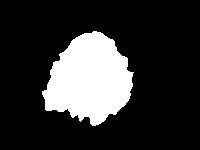</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget - c https: // https://disk.yandex.ru/d/Dkd-DE_ubDOwLw/PH2Dataset.rar

--2023-04-25 05:36:35--  http://-/
Resolving - (-)... failed: Name or service not known.
wget: unable to resolve host address ‘-’
--2023-04-25 05:36:35--  http://c/
Resolving c (c)... failed: Name or service not known.
wget: unable to resolve host address ‘c’
--2023-04-25 05:36:35--  ftp://https/
           => ‘.listing’
Resolving https (https)... failed: Name or service not known.
wget: unable to resolve host address ‘https’
//: Scheme missing.
--2023-04-25 05:36:35--  https://disk.yandex.ru/d/Dkd-DE_ubDOwLw/PH2Dataset.rar
Resolving disk.yandex.ru (disk.yandex.ru)... 87.250.250.50, 2a02:6b8::2:50
Connecting to disk.yandex.ru (disk.yandex.ru)|87.250.250.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29126 (28K) [text/html]
Saving to: ‘PH2Dataset.rar.2’

PH2Dataset.rar.2    100%[===================>]  28.44K   162KB/s    in 0.2s    

2023-04-25 05:36:37 (162 KB/s) - ‘PH2Dataset.rar.2’ saved [29126/29126]

FINISHED --2023-04-25 05:36:37--
Total wall clock ti

In [ ]:
!ls
# if need to delete PH2Dataset folder
# import shutil
# shutil.rmtree('PH2Dataset')

PH2Dataset  PH2Dataset.rar  PH2Dataset.rar.1  PH2Dataset.rar.2	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
import os
from skimage.io import imread
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False)
     > 0.5 for y in lesions]


In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')


Loaded 200 images


In [ ]:
len(lesions)


200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

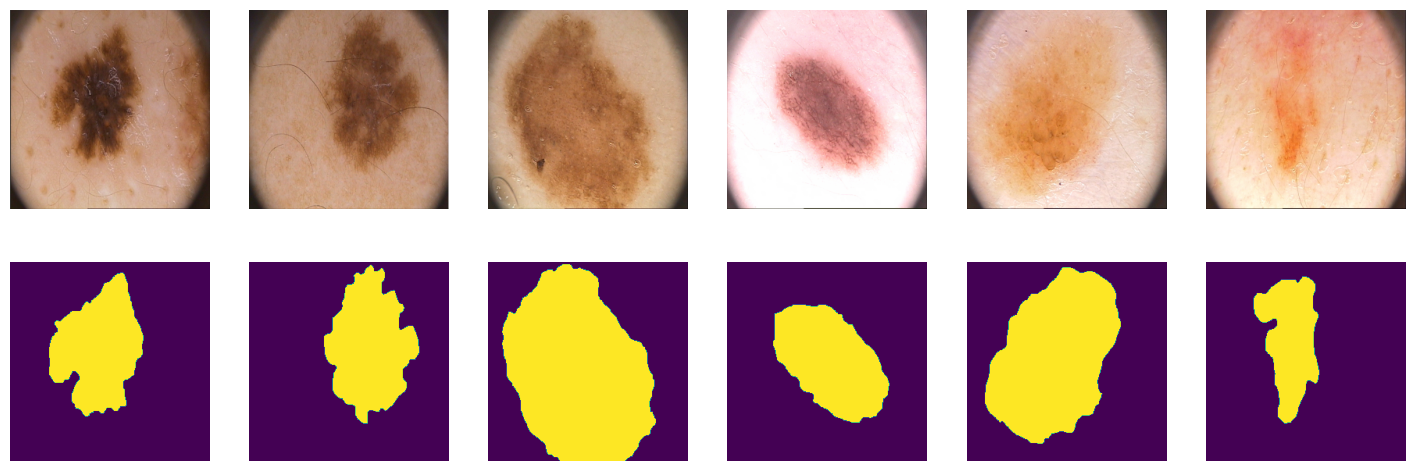

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()


Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])


In [ ]:
print(len(tr), len(val), len(ts))


100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 16
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)


In [ ]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)


cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

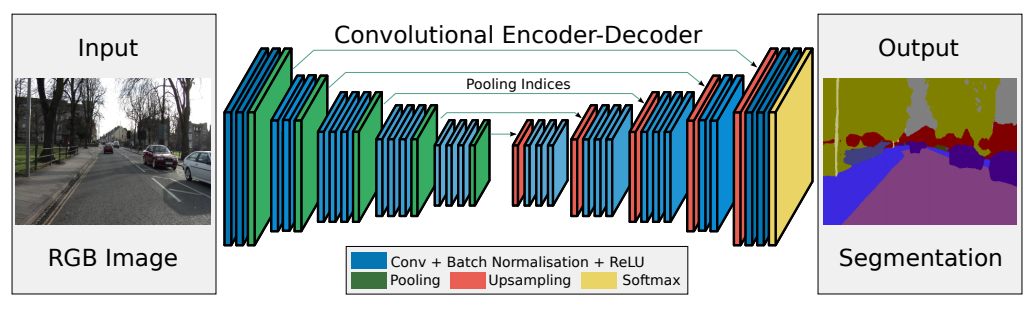

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchvision import datasets, models, transforms

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)


в статье говорится, что энкодер содержит 13 слоёв, которые совпадают со слоями VGG16. Посмотрим на слои VGG16

In [ ]:
# models.vgg16_bn()

In [ ]:
# сделаем отдельный класс для Conv2d-BatchNorm2d-ReLU
class conv2dBatchNorm2dReLU(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding):
        super(conv2dBatchNorm2dReLU, self).__init__()

        self.unit = nn.Sequential(
            nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size, padding=padding, stride=stride),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        return self.unit(inputs)


class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            conv2dBatchNorm2dReLU(3, 64, 3, 1, 1),
            conv2dBatchNorm2dReLU(64, 64, 3, 1, 1),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 
                                  ceil_mode=False, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            conv2dBatchNorm2dReLU(64, 128, 3, 1, 1),
            conv2dBatchNorm2dReLU(128, 128, 3, 1, 1),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 
                                  ceil_mode=False, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            conv2dBatchNorm2dReLU(128, 256, 3, 1, 1),
            conv2dBatchNorm2dReLU(256, 256, 3, 1, 1),
            conv2dBatchNorm2dReLU(256, 256, 3, 1, 1),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 
                                  ceil_mode=False, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            conv2dBatchNorm2dReLU(256, 512, 3, 1, 1),
            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1),
            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 
                                  ceil_mode=False, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1),  # part 1
            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1),
            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1),

            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1),  # part 2
            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1),
            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            conv2dBatchNorm2dReLU(512, 256, 3, 1, 1),
            conv2dBatchNorm2dReLU(256, 256, 3, 1, 1),
            conv2dBatchNorm2dReLU(256, 256, 3, 1, 1),
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            conv2dBatchNorm2dReLU(256, 128, 3, 1, 1),
            conv2dBatchNorm2dReLU(128, 128, 3, 1, 1),
            conv2dBatchNorm2dReLU(128, 128, 3, 1, 1),
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            conv2dBatchNorm2dReLU(128, 64, 3, 1, 1),
            conv2dBatchNorm2dReLU(64, 64, 3, 1, 1),
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            conv2dBatchNorm2dReLU(64, 32, 3, 1, 1),
            conv2dBatchNorm2dReLU(32, 1, 3, 1, 1),
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample0(d2, ind0))  
        
        # no activation
        return d3


## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum(
        (1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum(
        (1, 2))         # Will be zzero if both are 0

    # We smooth our devision to avoid 0/0
    iou = (intersection + SMOOTH) / (union + SMOOTH)

    # This is equal to comparing with thresolds
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded  #


## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    loss = y_pred - y_real*y_pred + (1 + torch.exp(-y_pred)).log()
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, score_model, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    losses_train = []
    losses_val = []
    scores_train = []
    scores_val = []
    for epoch in range(epochs):
        torch.cuda.empty_cache()
        # print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to DEVICE
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        # print('train loss: %f' % avg_loss)
        losses_train.append(avg_loss.tolist())

        # show intermediate results
        model.eval()  # testing mode
        
        avg_score_train = score_model(model, iou_pytorch, data_tr, DEVICE)
        scores_train.append(avg_score_train)

        # val loss
        avg_loss_val = 0
        model.eval()  # testing mode
        for X_val, Y_val in data_val:
            with torch.no_grad():
                Y_hat = model(X_val.to(DEVICE)).detach().cpu()# detach and put into cpu

                loss = loss_fn(Y_hat, Y_val) # forward-pass
                avg_loss_val += loss / len(data_val)

        # print('val_loss: %f' % avg_loss_val)
        losses_val.append(avg_loss_val.tolist())

        # val score
        avg_score_val = score_model(model, iou_pytorch, data_val, DEVICE)
        scores_val.append(avg_score_val)

    return (losses_train, losses_val, scores_train, scores_val)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)


In [ ]:
def score_model(model, metric, data, device):
    model.eval()  # testing mode
    torch.cuda.empty_cache()
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_pred = torch.ones_like(Y_pred) * (Y_pred > 0.1)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)


## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
# clear cuda cache
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())

# DEVICE = 'cpu'
model_bce = SegNet().to(DEVICE)

max_epochs = 50
optimizer = torch.optim.AdamW(model_bce.parameters(), lr=0.00100, weight_decay=0.05)
history_bce = train(model_bce, optimizer, bce_loss, max_epochs, score_model, data_tr, data_val)

In [ ]:
score_model(model_bce, iou_pytorch, data_val, DEVICE)

0.714062511920929

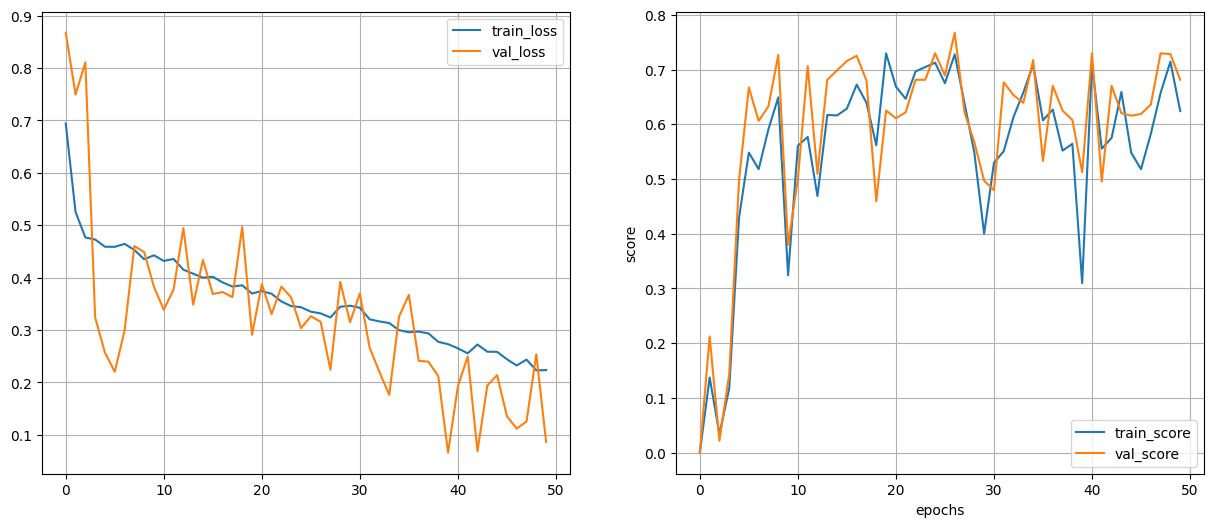

In [ ]:
def plot_results(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6
                                            ))
    axes[0].plot(history[0], label="train_loss")
    axes[0].plot(history[1], label="val_loss")
    axes[0].grid()
    axes[0].legend()

    axes[1].plot(history[2], label="train_score")
    axes[1].plot(history[3], label="val_score")
    axes[1].grid()
    axes[1].legend()
    plt.xlabel("epochs")
    plt.ylabel("score")
    plt.show()

plot_results(history_bce)

Ответьте себе на вопрос: не переобучается ли моя модель?

Судя по тому, что скор на валидационной выборке не уменьшается, модель не переобучается

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real):

    smooth = 1e-8
    outputs = y_pred.sigmoid().squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = y_real.squeeze(1)    

    i = (outputs * labels).sum()
    s = (outputs + labels).sum()
    r = 1 - ((2. * i + smooth) / (s + smooth))#/(256*256)
    
    return r 

Проводим тестирование:

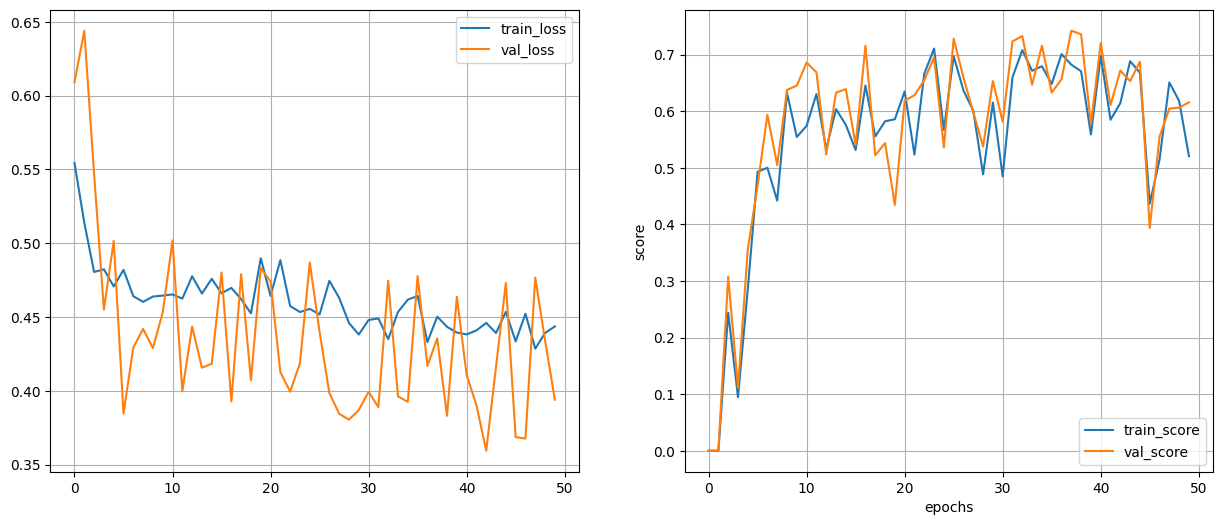

0.6375000178813934


In [ ]:
torch.cuda.empty_cache()

model_dise = SegNet().to(DEVICE)

max_epochs = 50

optimizer = torch.optim.AdamW(model_dise.parameters(), lr=0.00100, weight_decay=0.05)
history_dice = train(model_dise, optimizer, dice_loss, max_epochs, score_model, data_tr, data_val)
plot_results(history_dice)
print(score_model(model_dise, iou_pytorch, data_val, DEVICE))

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1) 
    
    loss = -torch.mean(
        ((1 - torch.sigmoid(y_pred)) ** gamma) * y_real * torch.log(torch.sigmoid(y_pred) + eps) + (1 - y_real) * torch.log(
        1 - torch.sigmoid(y_pred) + eps))
    return loss


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

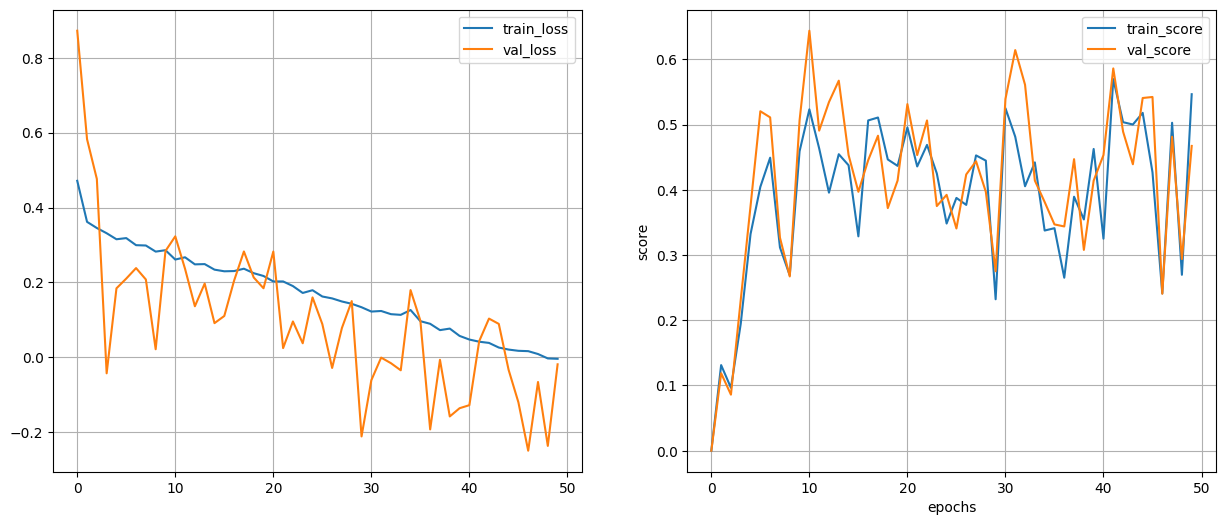

0.5000000074505806


In [ ]:
model_focal = SegNet().to(DEVICE)

max_epochs = 50

optimizer = torch.optim.AdamW(model_focal.parameters(), lr=0.00100, weight_decay=0.05)
history_focal = train(model_focal, optimizer, focal_loss, max_epochs, score_model, data_tr, data_val)
plot_results(history_focal)
print(score_model(model_focal, iou_pytorch, data_val, DEVICE))

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
# скажу честно - не уверен, что реализовал правильно:)
# loss с первой ссылки с лицами
# в статье говорится о карте "важности". 
# Относительно лиц - авторы делали, чтобы сеть обращала больше внимания
# на глаза, нос, рот, брови.
# В нашей работе всего 3 класса, поэтому не увидел смысла..
def facial_loss(y_pred, y_real, lam = 0.5):
    x_real, x_pred = y_real, y_pred  # х - карта важности сегментации
    y_pred_softmax = torch.nn.functional.softmax(y_pred)
    loss_classif = -sum(y_real * y_pred_softmax.log())
    loss_facial = sum((x_real - x_pred)**2)
    loss = loss_classif + lam*loss_facial
    return torch.mean(loss)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

<ipython-input-27-4d3dccb753b4>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred_softmax = torch.nn.functional.softmax(y_pred)


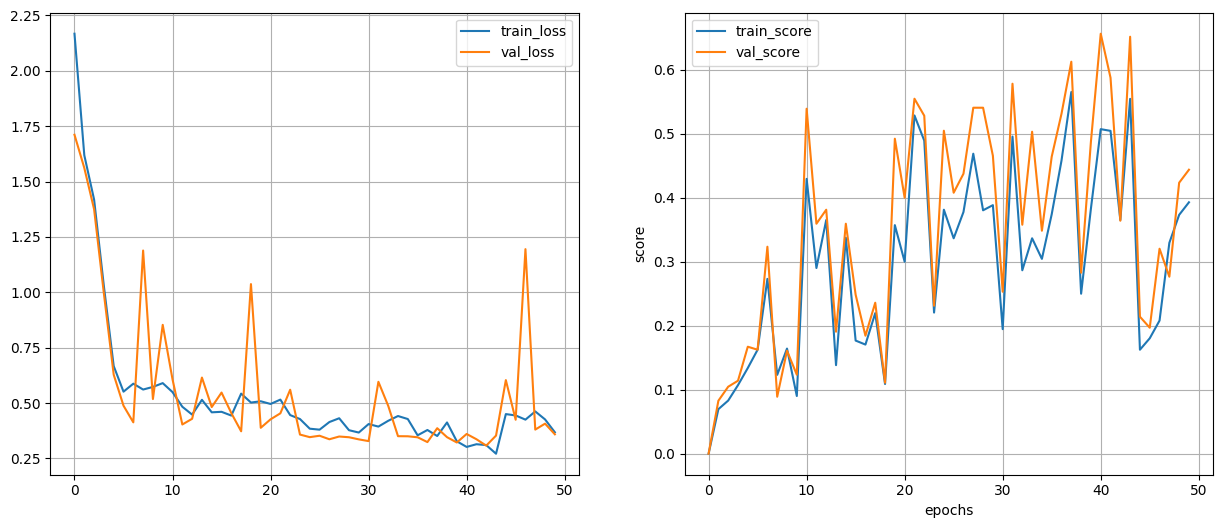

0.4437500014901161


In [ ]:
model_fac = SegNet().to(DEVICE)

max_epochs = 50

optimizer = torch.optim.AdamW(model_fac.parameters(), lr=0.00100, weight_decay=0.05)
history_fac = train(model_fac, optimizer, facial_loss, max_epochs, score_model, data_tr, data_val)
plot_results(history_fac)
print(score_model(model_fac, iou_pytorch, data_val, DEVICE))

In [ ]:
# BCE Soft Targets
# параметр temperature используется для настройки "мягких целей" (soft targets)
import torch.nn.functional as F
def bce_soft_targets_loss(y_true, y_pred, temperature=1.3):
    y_true_soft = (y_true / temperature)
    return bce_loss(y_pred, y_true_soft)

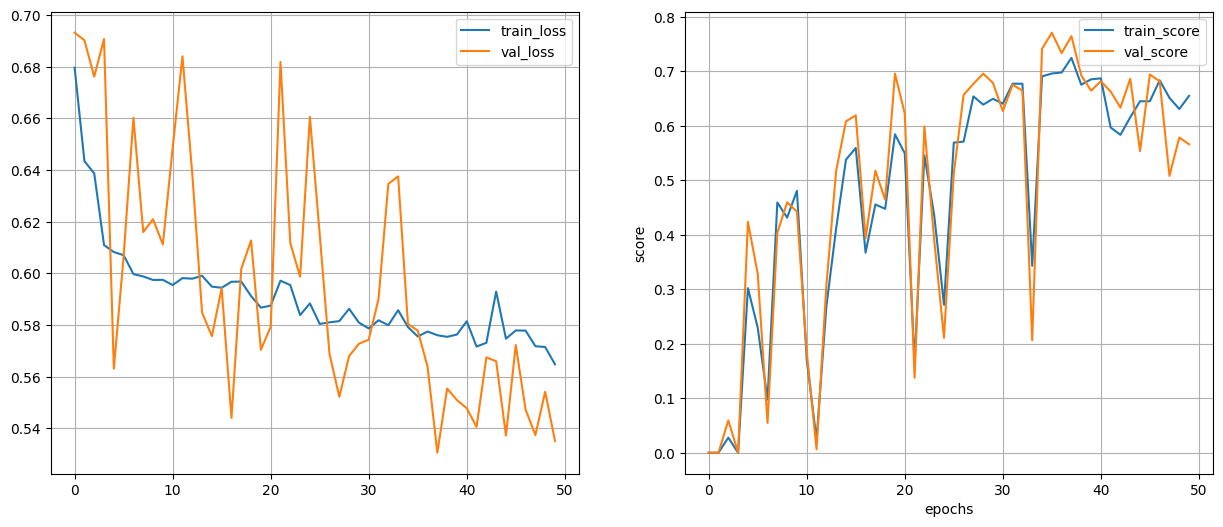

0.6421875059604645


In [ ]:
gc.collect()
torch.cuda.empty_cache()

model_st = SegNet().to(DEVICE)

max_epochs = 50

optimizer = torch.optim.AdamW(model_st.parameters(), lr=0.00100, weight_decay=0.05)
history_st = train(model_st, optimizer, bce_soft_targets_loss, max_epochs, score_model, data_tr, data_val)
plot_results(history_st)
print(score_model(model_st, iou_pytorch, data_val, DEVICE))

ну, как-то обучилась

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

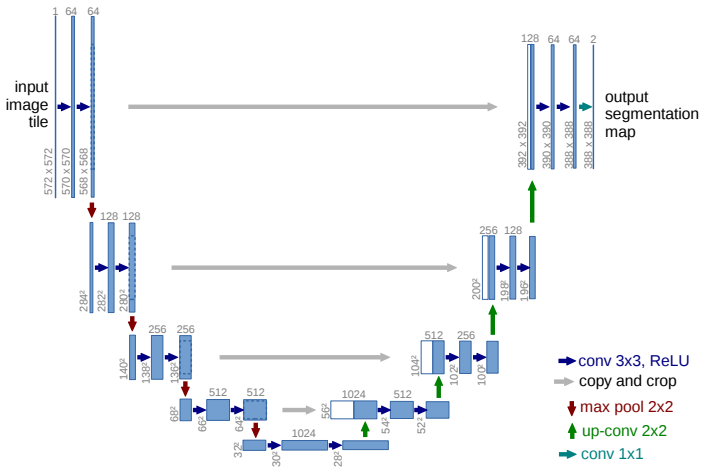

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class conv2dBatchNorm2dReLU(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding):
        super(conv2dBatchNorm2dReLU, self).__init__()

        self.unit = nn.Sequential(
            nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size, padding=padding, stride=stride),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        return self.unit(inputs)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            conv2dBatchNorm2dReLU(3, 64, 3, 1, 1),
            conv2dBatchNorm2dReLU(64, 64, 3, 1, 1),
        )
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            conv2dBatchNorm2dReLU(64, 128, 3, 1, 1),
            conv2dBatchNorm2dReLU(128, 128, 3, 1, 1),
        )
        self.pool1 = nn.MaxPool2d(2, 2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            conv2dBatchNorm2dReLU(128, 256, 3, 1, 1),
            conv2dBatchNorm2dReLU(256, 256, 3, 1, 1),
        )
        self.pool2 = nn.MaxPool2d(2, 2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            conv2dBatchNorm2dReLU(256, 512, 3, 1, 1),
            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1),
        )
        self.pool3 = nn.MaxPool2d(2, 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            conv2dBatchNorm2dReLU(512, 1024, 3, 1, 1),
            conv2dBatchNorm2dReLU(1024, 512, 3, 1, 1),
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            conv2dBatchNorm2dReLU(1024, 512, 3, 1, 1),
            conv2dBatchNorm2dReLU(512, 256, 3, 1, 1),
        )
        self.upsample1 = nn.Upsample(64, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            conv2dBatchNorm2dReLU(512, 256, 3, 1, 1),
            conv2dBatchNorm2dReLU(256, 128, 3, 1, 1),
        )
        self.upsample2 = nn.Upsample(128, mode='bilinear')  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            conv2dBatchNorm2dReLU(256, 128, 3, 1, 1),
            conv2dBatchNorm2dReLU(128, 64, 3, 1, 1),
        )
        self.upsample3 = nn.Upsample(256, mode='bilinear')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0_ = self.enc_conv0(x) # 256
        e0 = self.pool0(e0_)
        e1_ = self.enc_conv1(e0) # 128
        e1 = self.pool1(e1_)
        e2_ = self.enc_conv2(e1) # 64
        e2 = self.pool2(e2_)
        e3 = self.enc_conv3(e2) #32

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) #32-16

        # decoder
        d0 = self.upsample0(b) # 32
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        
        d1 = self.upsample1(d0) # 64
        d1 = torch.cat([d1, e2_], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1) # 128
        d2 = torch.cat([d2, e1_], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2) # 256
        # print(np.shape(d3))
        d3 = torch.cat([d3, e0_], dim=1)
        d3 = self.dec_conv3(d3)
        # print(np.shape(d3))
        
        # no activation
        return d3


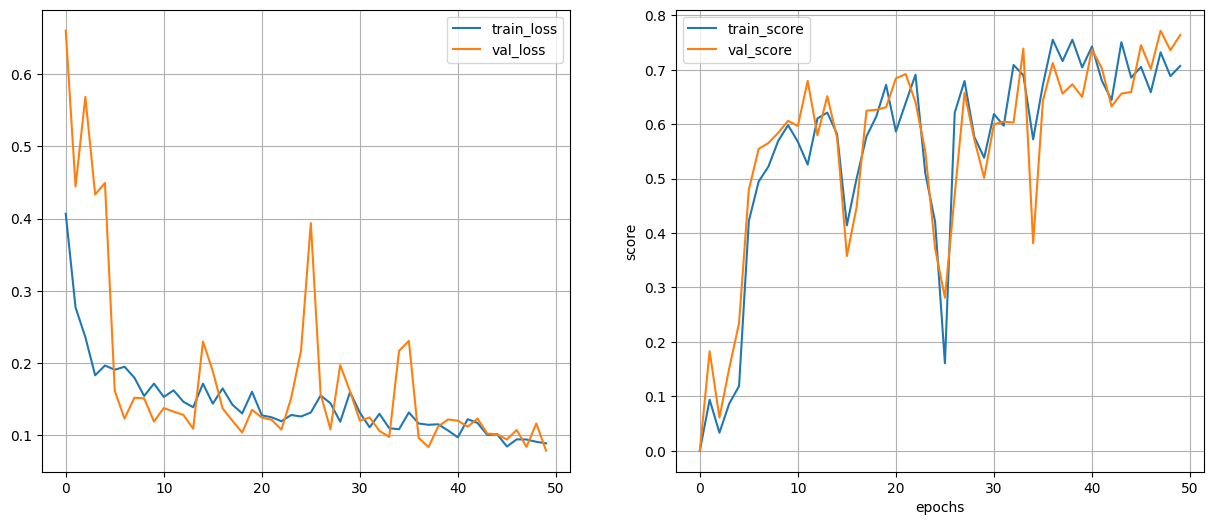

0.7203125059604645


In [ ]:
gc.collect()
torch.cuda.empty_cache()

model_unet = UNet().to(DEVICE)

max_epochs = 50

optimizer = torch.optim.AdamW(model_unet.parameters(), lr=0.001, weight_decay=0.05)
history_unet = train(model_unet, optimizer, dice_loss, max_epochs, score_model, data_tr, data_val)
plot_results(history_unet)
print(score_model(model_unet, iou_pytorch, data_val, DEVICE))


In [ ]:
gc.collect()
torch.cuda.empty_cache()

Новая модель путем изменения типа пулинга:

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class conv2dBatchNorm2dReLU(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding):
        super(conv2dBatchNorm2dReLU, self).__init__()

        self.unit = nn.Sequential(
            nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size, padding=padding, stride=stride),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        return self.unit(inputs)

class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            conv2dBatchNorm2dReLU(3, 64, 3, 1, 1),
            conv2dBatchNorm2dReLU(64, 64, 3, 1, 1), 
        )
        self.pool0 = conv2dBatchNorm2dReLU(64, 64, 3, 2, 1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            conv2dBatchNorm2dReLU(64, 128, 3, 1, 1),
            conv2dBatchNorm2dReLU(128, 128, 3, 1, 1),
        )
        self.pool1 = conv2dBatchNorm2dReLU(128, 128, 3, 2, 1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            conv2dBatchNorm2dReLU(128, 256, 3, 1, 1),
            conv2dBatchNorm2dReLU(256, 256, 3, 1, 1),
        )
        self.pool2 = conv2dBatchNorm2dReLU(256, 256, 3, 2, 1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            conv2dBatchNorm2dReLU(256, 512, 3, 1, 1),
            conv2dBatchNorm2dReLU(512, 512, 3, 1, 1), 
        )
        self.pool3 = conv2dBatchNorm2dReLU(512, 512, 3, 2, 1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            conv2dBatchNorm2dReLU(512, 1024, 3, 1, 1),
            conv2dBatchNorm2dReLU(1024, 512, 3, 1, 1),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            conv2dBatchNorm2dReLU(1024, 512, 3, 1, 1),
            conv2dBatchNorm2dReLU(512, 256, 3, 1, 1),
        )
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            conv2dBatchNorm2dReLU(512, 256, 3, 1, 1),
            conv2dBatchNorm2dReLU(256, 128, 3, 1, 1),
        )
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            conv2dBatchNorm2dReLU(256, 128, 3, 1, 1),
            conv2dBatchNorm2dReLU(128, 64, 3, 1, 1),
        )
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0_ = self.enc_conv0(x) # 256
        e0 = self.pool0(e0_)
        e1_ = self.enc_conv1(e0) # 128

        e1 = self.pool1(e1_)
        e2_ = self.enc_conv2(e1) # 64
        e2 = self.pool2(e2_)
        e3_ = self.enc_conv3(e2) #32
        e3 = self.pool3(e3_)

        # bottleneck
        b = self.bottleneck_conv(e3) #32-16

        # decoder
        d0 = self.upsample0(b) # 32
        d0 = torch.cat([d0, e3_], dim=1)
        d0 = self.dec_conv0(d0)
        
        d1 = self.upsample1(d0) # 64
        d1 = torch.cat([d1, e2_], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1) # 128
        d2 = torch.cat([d2, e1_], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2) # 256
        d3 = torch.cat([d3, e0_], dim=1)
        d3 = self.dec_conv3(d3)
        
        # no activation
        return d3

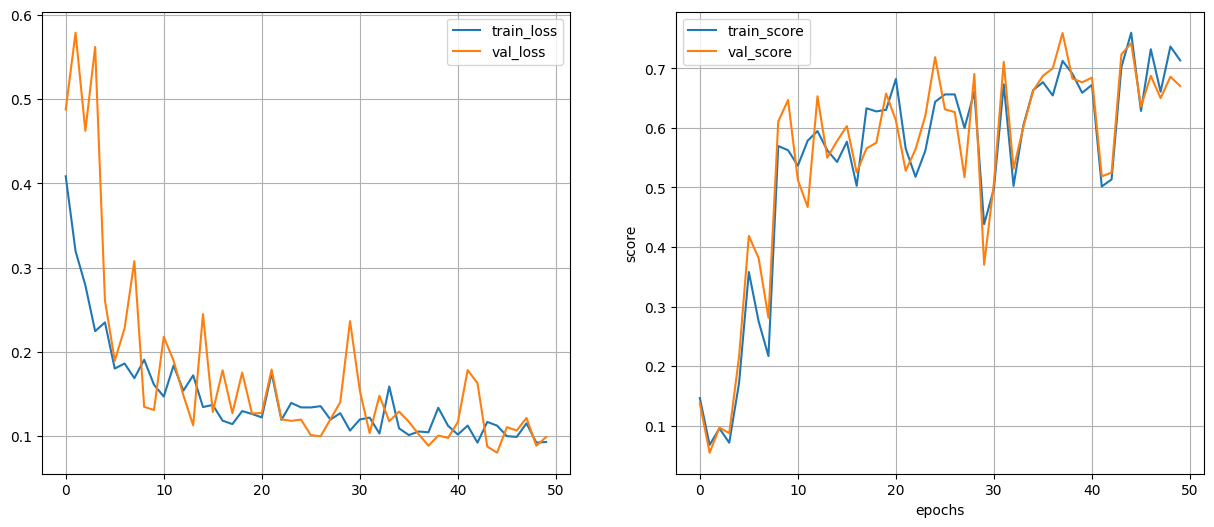

0.7359375208616257


In [ ]:
gc.collect()
torch.cuda.empty_cache()

model_unet2 = UNet2().to(DEVICE)

max_epochs = 50

optimizer = torch.optim.AdamW(model_unet2.parameters(), lr=0.001, weight_decay=0.05)
history_unet2 = train(model_unet2, optimizer, dice_loss, max_epochs, score_model, data_tr, data_val)
plot_results(history_unet2)
print(score_model(model_unet2, iou_pytorch, data_val, DEVICE))

<ipython-input-27-4d3dccb753b4>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred_softmax = torch.nn.functional.softmax(y_pred)


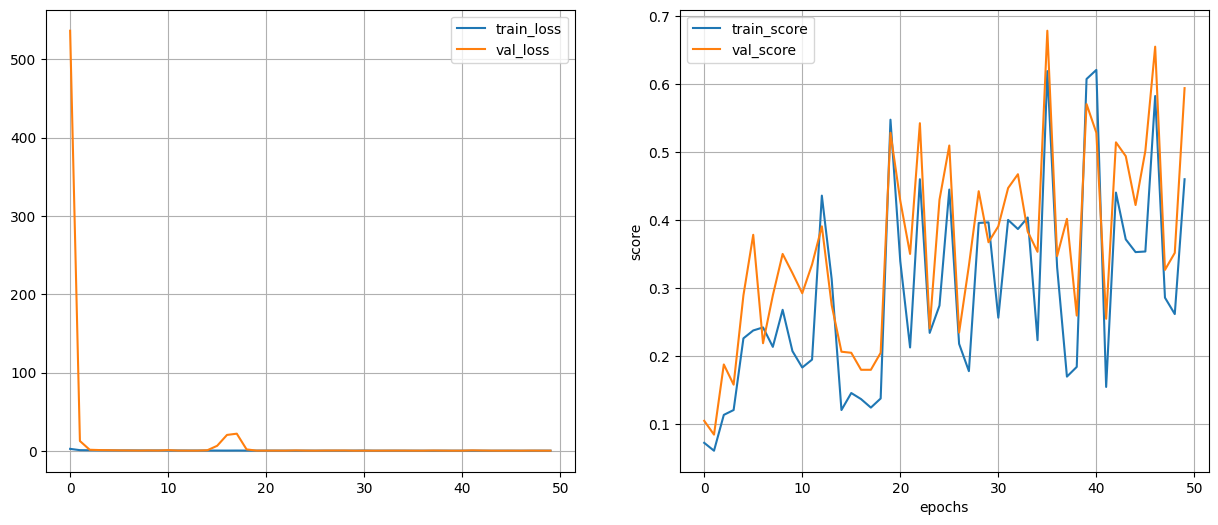

0.49531250447034836


In [ ]:
# попробуем facial loss
gc.collect()
torch.cuda.empty_cache()

model_unet2_fac = UNet2().to(DEVICE)

max_epochs = 50

optimizer = torch.optim.AdamW(model_unet2_fac.parameters(), lr=0.001, weight_decay=0.05)
history_unet2_fac = train(model_unet2_fac, optimizer, facial_loss, max_epochs, score_model, data_tr, data_val)
plot_results(history_unet2_fac)
print(score_model(model_unet2_fac, iou_pytorch, data_val, DEVICE))

оочень плохо, но учится.

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

В работе мы изучали сегментацию изображений. Были построены две архитектуры сегментации: segnet и Unet. При обучении моделей использовались различные функции потерь.  
<br><br>
Проведем анализ функций потерь для архитектуры segnet

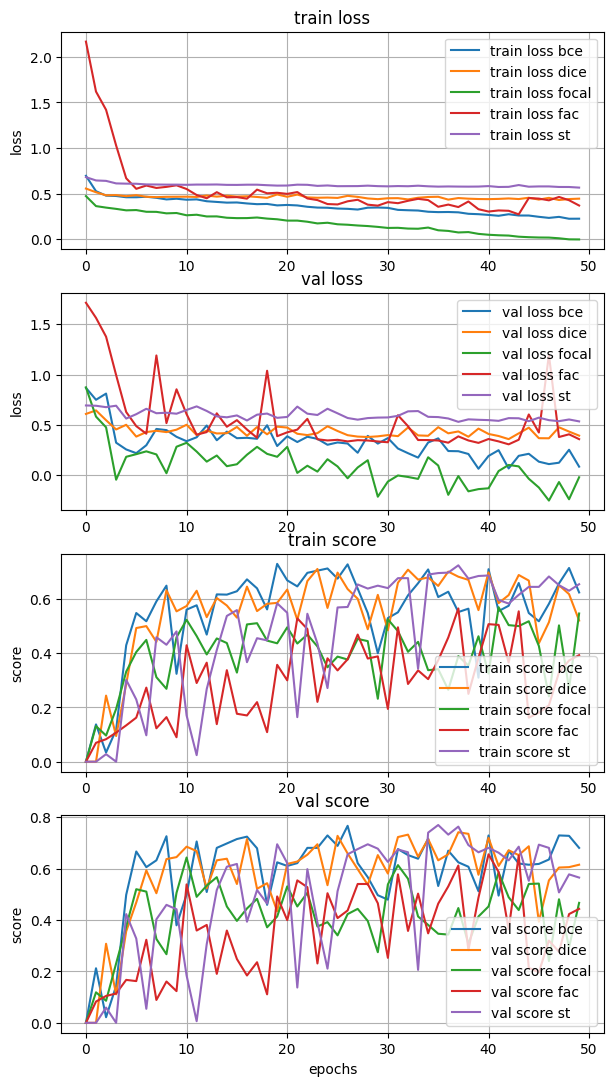

In [ ]:
history = [
    history_bce,
    history_dice,
    history_focal,
    history_fac,
    history_st,
]

name = [
    'bce',
    'dice',
    'focal',
    'fac',
    'st',
]

fig, axes = plt.subplots(4, 1, figsize=(7, 13))
for i, hist in enumerate(history):
    axes[0].plot(hist[0], label=f"train loss {name[i]}")
    axes[0].grid()
    axes[0].set_title('train loss')
    axes[0].set_ylabel('loss')
    axes[0].legend()

    axes[1].plot(hist[1], label=f"val loss {name[i]}")
    axes[1].grid()
    axes[1].set_title('val loss')
    axes[1].set_ylabel('loss')
    axes[1].legend()

    axes[2].plot(hist[2], label=f"train score {name[i]}")
    axes[2].grid()
    axes[2].set_title('train score')
    axes[2].set_ylabel('score')
    axes[2].legend()

    axes[3].plot(hist[3], label=f"val score {name[i]}")
    axes[3].grid()
    axes[3].set_title('val score')
    axes[3].set_ylabel('score')
    axes[3].legend()
    plt.xlabel("epochs")
    plt.ylabel("score")

plt.show()


Из графиков видно, что лучший результат score показывают модели с bce loss и Soft Targets (как наследник bce). 
<br><br>
Сравним качество инференса моделей на тестовой и валидационной выборке

In [ ]:
model_list = [
    model_bce,
    model_dise,
    model_focal,
    model_fac,
    model_st,
]

name = [
    'bce',
    'dice',
    'focal',
    'fac',
    'st',
]

for i, model in enumerate(model_list):
    score = score_model(model, iou_pytorch, data_ts, DEVICE)
    score_val = score_model(model, iou_pytorch, data_val, DEVICE)
    print(f'test score for model {name[i]} = \t{score}',
          f'\t valid score = \t{score_val}')

test score for model bce = 	0.550000011920929 	 valid score = 	0.6046875342726707
test score for model dice = 	0.5953124985098839 	 valid score = 	0.6375000178813934
test score for model focal = 	0.526562511920929 	 valid score = 	0.5
test score for model fac = 	0.3906250074505806 	 valid score = 	0.4437500089406967
test score for model st = 	0.620312511920929 	 valid score = 	0.6859375238418579


в результате обучения с разными функциями ошибками, наибольший score составил 0.62 у модели обученной на bce+soft_targets loss.

<br><br>
Сравним реализации Unet с upscale, convtranspose2d. Для unet попробовал использовать focal loss и facial loss, однако они значительно хуже 

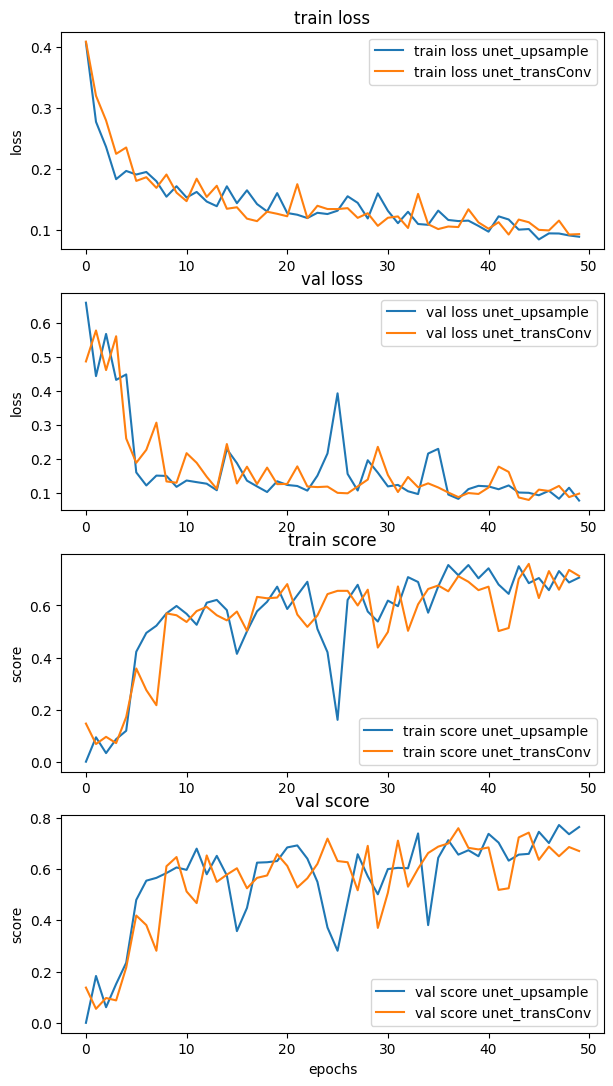

In [ ]:
history = [
    history_unet,
    history_unet2,
]
name = [
    'unet_upsample',
    'unet_transConv',
]

fig, axes = plt.subplots(4, 1, figsize=(7, 13))
for i, hist in enumerate(history):
    axes[0].plot(hist[0], label=f"train loss {name[i]}")
    axes[0].grid()
    axes[0].set_title('train loss')
    axes[0].set_ylabel('loss')
    axes[0].legend()

    axes[1].plot(hist[1], label=f"val loss {name[i]}")
    axes[1].grid()
    axes[1].set_title('val loss')
    axes[1].set_ylabel('loss')
    axes[1].legend()

    axes[2].plot(hist[2], label=f"train score {name[i]}")
    axes[2].grid()
    axes[2].set_title('train score')
    axes[2].set_ylabel('score')
    axes[2].legend()

    axes[3].plot(hist[3], label=f"val score {name[i]}")
    axes[3].grid()
    axes[3].set_title('val score')
    axes[3].set_ylabel('score')
    axes[3].legend()
    plt.xlabel("epochs")
    plt.ylabel("score")

plt.show()

In [ ]:
model_list = [
    model_unet,
    model_unet2,
]

name = [
    'unet_upsample',
    'unet_transConv',
]

for i, model in enumerate(model_list):
    score = score_model(model, iou_pytorch, data_ts, DEVICE)
    score_val = score_model(model, iou_pytorch, data_val, DEVICE)
    print(f'test score for model {name[i]} = \t{score}',
          f'\t valid score = \t{score_val}')

test score for model unet_upsample = 	0.667187511920929 	 valid score = 	0.7203125208616257
test score for model unet_transConv = 	0.6515624970197678 	 valid score = 	0.692187488079071


Из графиков обучения Unet видно, что модель с transposeConv лучше противостоит переобучению, и в целом обучается более плавно. Однако, в результате обучения на 50 эпохах, качество у unet с upsample лучше и составляет 0.667, тогда как у модели с transposeConv 0.65.
Попробуем увеличить количество эпох обучения до 100. Также, сравним функции потерь bce и dice.

In [ ]:
gc.collect()
torch.cuda.empty_cache()

model_unet = UNet().to(DEVICE)

max_epochs = 100

optimizer = torch.optim.AdamW(model_unet.parameters(), lr=0.001, weight_decay=0.05)
history_unet = train(model_unet, optimizer, bce_loss, max_epochs, score_model, data_tr, data_val)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

model_unet_dice = UNet().to(DEVICE)

max_epochs = 100

optimizer = torch.optim.AdamW(model_unet_dice.parameters(), lr=0.001, weight_decay=0.05)
history_unet_dice = train(model_unet_dice, optimizer, dice_loss, max_epochs, score_model, data_tr, data_val)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

model_unet2 = UNet2().to(DEVICE)

max_epochs = 100

optimizer = torch.optim.AdamW(model_unet2.parameters(), lr=0.001, weight_decay=0.05)
history_unet2 = train(model_unet2, optimizer, bce_loss, max_epochs, score_model, data_tr, data_val)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

model_unet2_dice = UNet2().to(DEVICE)

max_epochs = 100

optimizer = torch.optim.AdamW(model_unet2_dice.parameters(), lr=0.001, weight_decay=0.05)
history_unet2_dice = train(model_unet2_dice, optimizer, dice_loss, max_epochs, score_model, data_tr, data_val)

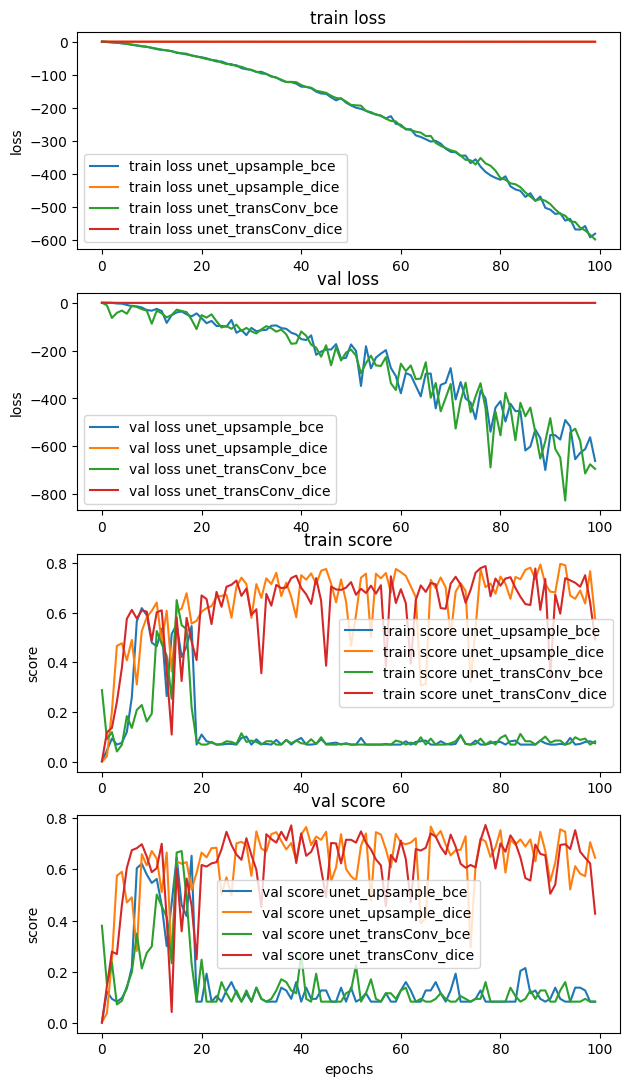

In [ ]:
history = [
    history_unet,
    history_unet_dice,
    history_unet2,
    history_unet2_dice,
]
name = [
    'unet_upsample_bce',
    'unet_upsample_dice',
    'unet_transConv_bce',
    'unet_transConv_dice',
]

fig, axes = plt.subplots(4, 1, figsize=(7, 13))
for i, hist in enumerate(history):
    axes[0].plot(hist[0], label=f"train loss {name[i]}")
    axes[0].grid()
    axes[0].set_title('train loss')
    axes[0].set_ylabel('loss')
    axes[0].legend()

    axes[1].plot(hist[1], label=f"val loss {name[i]}")
    axes[1].grid()
    axes[1].set_title('val loss')
    axes[1].set_ylabel('loss')
    axes[1].legend()

    axes[2].plot(hist[2], label=f"train score {name[i]}")
    axes[2].grid()
    axes[2].set_title('train score')
    axes[2].set_ylabel('score')
    axes[2].legend()

    axes[3].plot(hist[3], label=f"val score {name[i]}")
    axes[3].grid()
    axes[3].set_title('val score')
    axes[3].set_ylabel('score')
    axes[3].legend()
    plt.xlabel("epochs")
    plt.ylabel("score")

plt.show()

In [ ]:
model_list = [
    model_unet,
    model_unet_dice,
    model_unet2,
    model_unet2_dice
]
name = [
    'unet_upsample_bce',
    'unet_upsample_dice',
    'unet_transConv_bce',
    'unet_transConv_dice',

]

for i, model in enumerate(model_list):
    score = score_model(model, iou_pytorch, data_ts, DEVICE)
    score_val = score_model(model, iou_pytorch, data_val, DEVICE)
    print(f'test score for model {name[i]} = \t{score}',
          f'\t valid score = \t{score_val}')

test score for model unet_upsample_bce = 	0.16250000521540642 	 valid score = 	0.08281249925494194
test score for model unet_upsample_dice = 	0.5890624970197678 	 valid score = 	0.6453125029802322
test score for model unet_transConv_bce = 	0.09687500377185643 	 valid score = 	0.08281250158324838
test score for model unet_transConv_dice = 	0.6031250134110451 	 valid score = 	0.5578125193715096


Из графиков видно, что у модели с bce loss, loss сразу пошел меньше 0.
Да и в целом, даже модели с dice loss на 100 эпохах явно переобучились...


## **Выводы**
В работе были реализованны две архитектуры для сегментации изображений: segnet и Unet. Были реализованны различные функции потерь. Модель segnet обучалась 5 раз на следующих функциях потерь: bce, bce+soft_targets, focal, facial, dice. Модель Unet обучалась на bce и dice loss. Декодер модели Unet реализован двумя способами: upsample и transpose convolution. 

В результате обучения, для модели segnet, в результате обучения на 50 эпохах, лучший результат показала функция потерь bce+soft_targets с метрикой IoU = 0.62 на тестовой выборке.
Модель Unet с upsample показала результат при 50 эпохах обучения и достигла IoU = 0.667.